# Importing Libraries 

In [1]:
!pip install torchsummary
 

In [2]:
# Data Manipulation
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
# Visualization
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Path Library
import pathlib
import os

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms,datasets
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
import albumentations
from albumentations.pytorch import ToTensorV2


#pytorch lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer


#logging 
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_key")
from pytorch_lightning.loggers import WandbLogger

In [3]:
#login to logging tool 
wandb.login(key=secret_value_0)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [5]:
def show_image(label, examples, df, image_path):
    image_list = list(df[df['labels'] == label]['image'].sample(frac=1)[:examples])
    plt.figure(figsize=(20,10))
    for i, img_name in enumerate(image_list):
        full_path = os.path.join(image_path, img_name)
        img = cv2.imread(full_path)
        plt.subplot(1 ,examples, i%examples +1)
        plt.axis('off')
        plt.imshow(img)
        plt.title(label)
    plt.show()

# Absolute File Paths for the Images 

In [6]:
train_img_file_paths = [filepath.absolute() for filepath in pathlib.Path('../input/plant-pathology-2021-fgvc8/train_images').glob('**/*')]
train_img_file_paths[0]

PosixPath('/kaggle/working/../input/plant-pathology-2021-fgvc8/train_images/a8d54d0d96517ab3.jpg')

# Exploratory Data Analysis


## Reading the dataset

In [7]:
train_df = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')
train_df.head()

image                           labels
0  800113bb65efe69e.jpg                          healthy
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2  80070f7fb5e2ccaa.jpg                             scab
3  80077517781fb94f.jpg                             scab
4  800cbf0ff87721f8.jpg                          complex

## Checking for null data 

In [8]:
train_df.isnull().sum()

image     0
labels    0
dtype: int64

## Unique Values & Counts of Train DF

In [9]:
unique_labels_counts = train_df.groupby(['labels']).count().sort_values('image', ascending=1)
unique_labels_counts.reset_index(inplace=True)

md = []
md_count = []
od = []
od_count = []

for index, row in unique_labels_counts.iterrows():
    tokens = str(row['labels']).split(' ')
    if len(tokens) > 1:
        md.append(row['labels'])
        md_count.append(row['image'])
    else:
        od.append(row['labels'])
        od_count.append(row['image'])
        
md_df = pd.DataFrame({
    'md_labels': md,
    'md_count': md_count
})

od_df = pd.DataFrame({
    'od_labels': od,
    'od_count': od_count
})

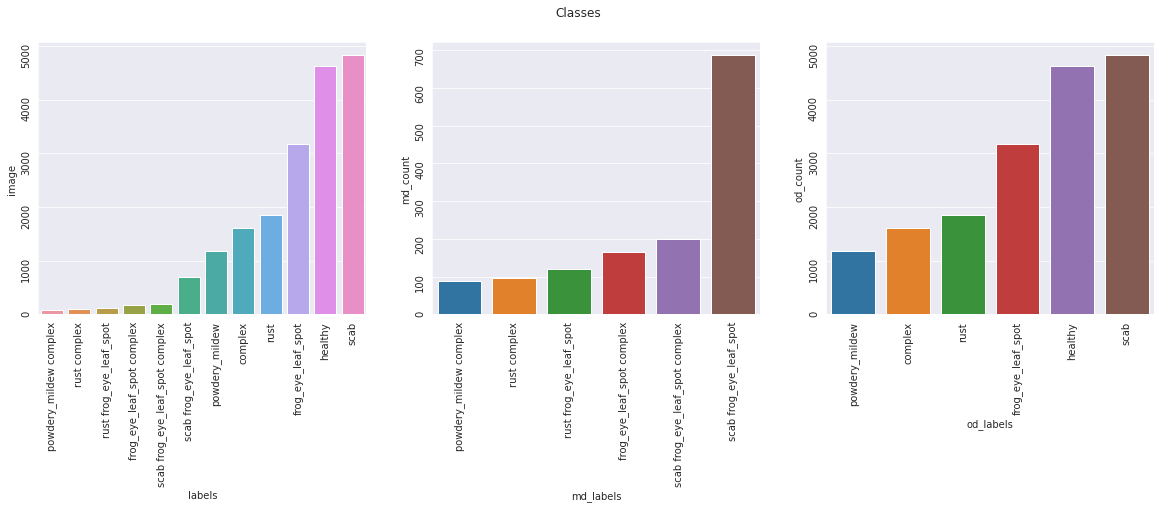

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
fig.suptitle('Classes')
sns.barplot(x='labels', y='image', data=unique_labels_counts, ax=axes[0])
sns.barplot(x='md_labels', y='md_count', data=md_df, ax=axes[1])
sns.barplot(x='od_labels', y='od_count', data=od_df, ax=axes[2])
for ax in fig.axes:
    ax.tick_params(labelrotation=90)
    
plt.show()

In [11]:
display_side_by_side([unique_labels_counts, md_df, od_df], ['All Disease Types', 'Multiple Diseases', 'Single Disease'])

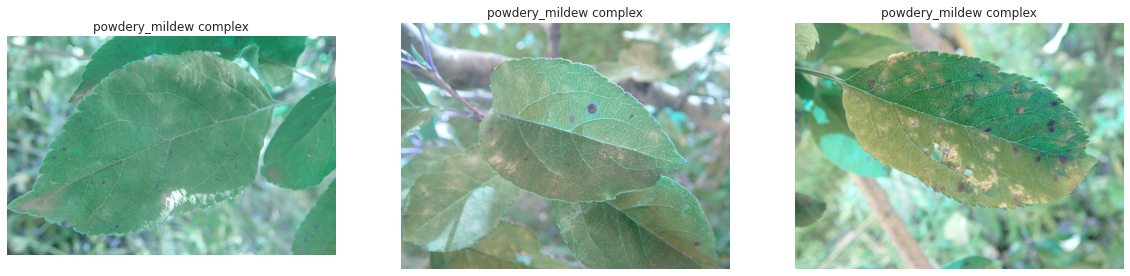

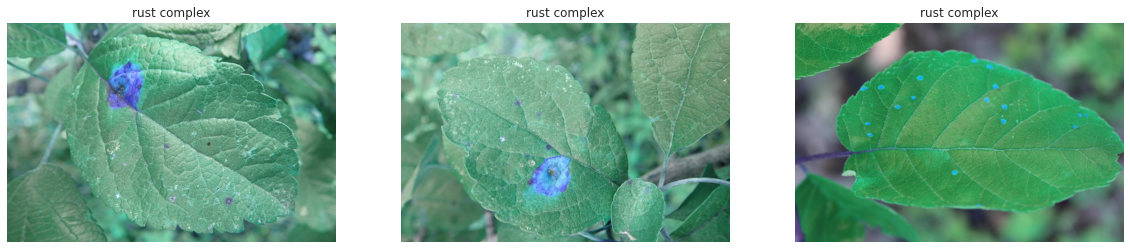

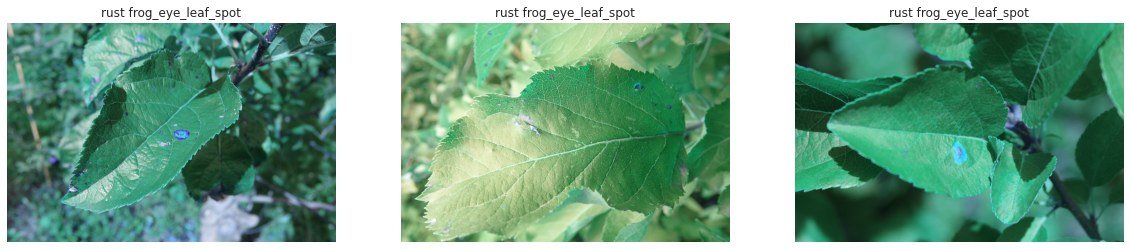

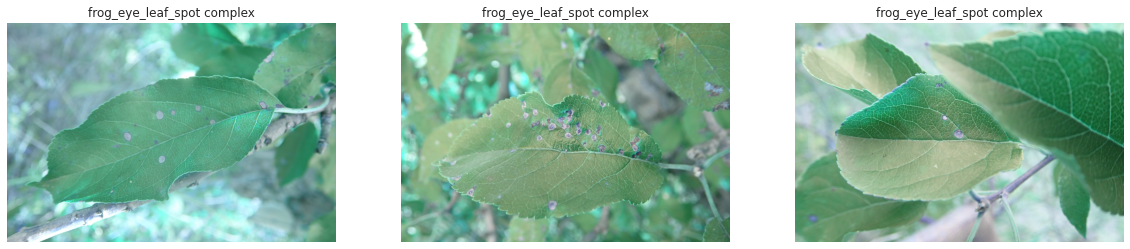

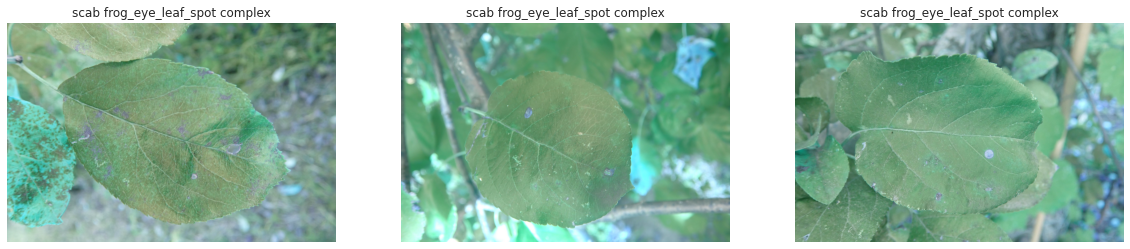

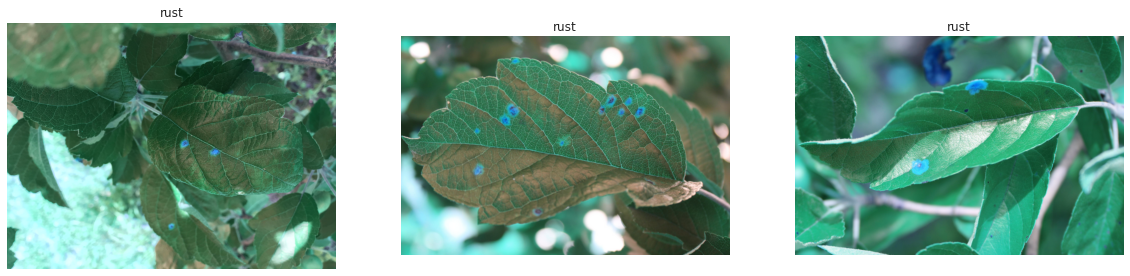

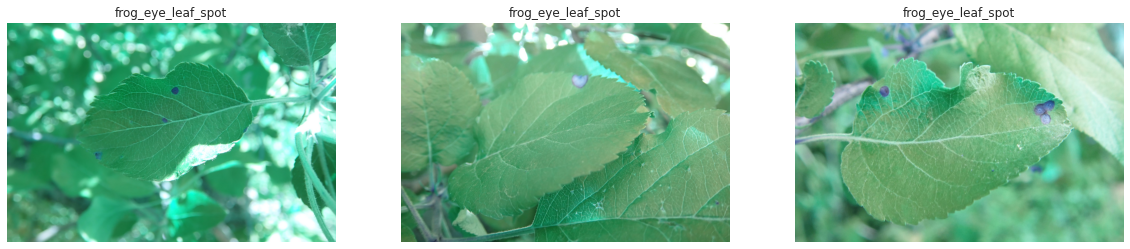

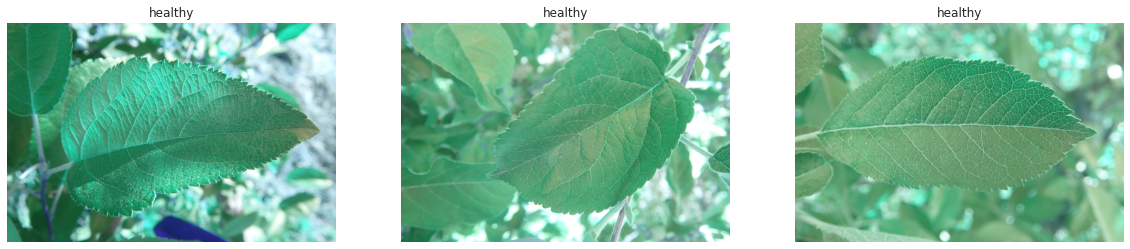

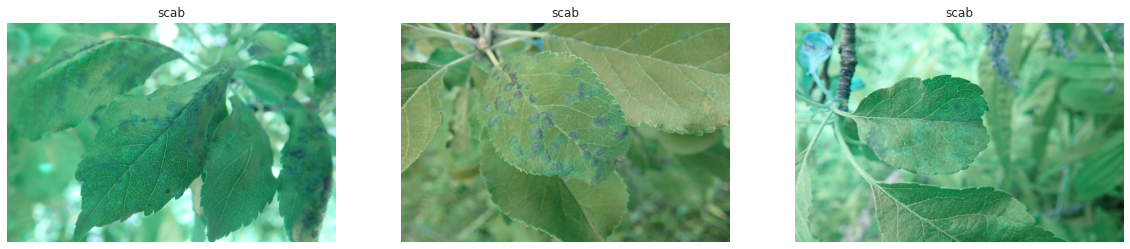

In [12]:
for row in unique_labels_counts['labels']:
    show_image(row, 3, train_df, '../input/plant-pathology-2021-fgvc8/train_images')

In [13]:
train_path = "../input/resized-plant2021/img_sz_640"
test_path ="../input/plant-pathology-2021-fgvc8/test_images"

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer         
lables = [i.split(" ") for i in train_df["labels"]]
mlb =MultiLabelBinarizer()
label_df = pd.DataFrame(mlb.fit_transform(lables),columns = mlb.classes_)
# df = pd.concat([train_df,label_df],axis = 1)
label_df

complex  frog_eye_leaf_spot  healthy  powdery_mildew  rust  scab
0            0                   0        1               0     0     0
1            1                   1        0               0     0     1
2            0                   0        0               0     0     1
3            0                   0        0               0     0     1
4            1                   0        0               0     0     0
...        ...                 ...      ...             ...   ...   ...
18627        0                   0        1               0     0     0
18628        0                   0        0               0     0     1
18629        0                   0        0               0     1     0
18630        0                   1        0               0     0     1
18631        0                   0        1               0     0     0

[18632 rows x 6 columns]

In [15]:
train_transformations = albumentations.Compose([
       albumentations.RandomResizedCrop(512,512, scale=(0.9, 1), p=1), 
       albumentations.HorizontalFlip(p=0.5),
       albumentations.VerticalFlip(p=0.5),
       albumentations.ShiftScaleRotate(p=0.5),
       albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
       albumentations.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
       albumentations.CLAHE(clip_limit=(1,4), p=0.5),
       albumentations.OneOf([
           albumentations.OpticalDistortion(distort_limit=1.0),
           albumentations.GridDistortion(num_steps=5, distort_limit=1.),
           albumentations.ElasticTransform(alpha=3),
       ], p=0.2),
       albumentations.OneOf([
           albumentations.GaussNoise(var_limit=[10, 50]),
           albumentations.GaussianBlur(),
           albumentations.MotionBlur(),
           albumentations.MedianBlur(),
       ], p=0.2),
      albumentations.Resize(512,512),
      albumentations.OneOf([
          albumentations.JpegCompression(),
          albumentations.Downscale(scale_min=0.1, scale_max=0.15),
      ], p=0.2),
      albumentations.IAAPiecewiseAffine(p=0.2),
      albumentations.IAASharpen(p=0.2),
      albumentations.Cutout(max_h_size=int(512 * 0.1), max_w_size=int(512 * 0.1), num_holes=5, p=0.5),
      albumentations.Normalize(),
      ToTensorV2()
    ])



val_transformations = albumentations.Compose([
    albumentations.Resize(512,512),
    albumentations.Normalize(),
    ToTensorV2(),

])

In [16]:
# train_transformations = transforms.Compose([
#     transforms.Resize(512),
#     transforms.RandomPerspective(),
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])



# val_transformations = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [17]:
class Dataset():
    def __init__(self,dataset_type,filelist,filepath,labels =None,transform = None):
        self.dataset_type=dataset_type
        self.filelist = filelist.values
        self.filepath = filepath
        self.transform = transform
        self.labels = labels.values
    def __len__(self):
        return int(len(self.filelist))
    def __getitem__(self,index):
        imgpath = os.path.join(self.filepath,self.filelist[index])
        im = cv2.imread(imgpath)
        img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)   # BGR -> RGB
#         img = Image.open(imgpath)
        label = self.labels[index]
        if self.transform is not None:
            img = self.transform(image = img)
        if self.dataset_type == "train":    
            return img["image"],torch.tensor(np.array(label))
            
        else:
            return img 

In [18]:
x_train,x_valid,y_train,y_valid = train_test_split(train_df["image"],label_df,test_size=0.2)
train_data = Dataset("train",x_train,train_path,y_train,train_transformations)
val_data = Dataset("train",x_valid,train_path,y_valid,val_transformations)

In [19]:
train_data.__getitem__(0)

(tensor([[[ 0.7762,  0.1426, -0.2513,  ...,  0.7762,  0.6734, -0.9534],
          [ 0.3309, -0.0972, -0.0116,  ...,  0.1939,  0.7933,  0.7591],
          [ 0.1939, -0.1143,  0.1254,  ..., -0.1828,  0.1254,  1.0331],
          ...,
          [ 0.6734,  0.8789,  0.4679,  ...,  0.2796,  0.2967, -0.3198],
          [ 0.1254,  0.8276,  0.8618,  ...,  0.4851,  0.2111, -0.1657],
          [-0.2684,  0.1254,  0.7591,  ...,  0.2624, -0.4568, -0.7308]],
 
         [[ 1.5882,  1.0105,  0.5728,  ...,  1.6408,  1.5182, -0.0224],
          [ 1.2031,  0.7479,  0.9055,  ...,  1.1331,  1.6232,  1.6057],
          [ 1.0280,  0.8004,  1.0105,  ...,  0.7129,  1.0805,  1.8683],
          ...,
          [ 1.6232,  1.5707,  1.0630,  ...,  1.2556,  1.2206,  0.5203],
          [ 1.0630,  1.6057,  1.5707,  ...,  1.4132,  1.0805,  0.7129],
          [ 0.6954,  1.0105,  1.5882,  ...,  1.1856,  0.4153,  0.1527]],
 
         [[ 0.1302, -0.4275, -0.7936,  ...,  0.4788,  0.3393, -1.2990],
          [-0.2184, -0.6541,

In [20]:
train_data.__len__()

14905

In [21]:
class covnet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.train_accuracy = pl.metrics.Accuracy()
        self.val_accuracy = pl.metrics.Accuracy()
        self.model = torchvision.models.resnet34(pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features,6)
        


#         self.conv1 = nn.Sequential(
#             nn.Conv2d(3,16,3),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2)
#             )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(16,32,3),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2)
#             )
#         self.fc1 = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(32*54*54,256),
#             nn.ReLU(),
#             nn.Linear(256,128),
#             nn.ReLU()
#         )
        
#         self.output = nn.Sequential(
#             nn.Linear(128,6),
#             nn.Sigmoid()
            
#         )

    def forward(self,x):
        return F.sigmoid(self.model(x)) 
        #pytorch lighning functions
    def configure_optimizers(self):
        optimiser = torch.optim.Adam(self.parameters(),lr=5e-04)
        lr_schduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimiser,20,1e-06)
        return [optimiser],[lr_schduler]
    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = F.binary_cross_entropy_with_logits(pred, y.to(float))
        self.train_accuracy(pred,y)
        self.log("train_loss_epoch", loss, on_step=False, on_epoch=True,prog_bar=True)
        self.log('train_acc_epoch', self.train_accuracy,on_step=False, on_epoch=True,prog_bar=True)
        return loss 
#     def training_epoch_end(self,output):
#         self.log('train_acc_epoch', self.train_accuracy(),on_step=True, on_epoch=True)
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        val_loss = F.binary_cross_entropy_with_logits(pred, y.to(float))
        self.val_accuracy(pred,y)
        self.log("val_loss_epoch", val_loss, on_step=False, on_epoch=True,prog_bar=True)
        self.log('val_acc_epoch', self.val_accuracy,on_step=False, on_epoch=True,prog_bar=True)
        return val_loss
#     def validation_epoch_end(self,outputs):
#         self.log('train_acc_epoch', self.train_accuracy(),on_step=True, on_epoch=True)
        
    
   

In [22]:
wandb.init(project="Plant Pathology 2021 ",reinit=True)

wandb: Currently logged in as: poipii (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [23]:
model = covnet()
model.cuda()
summary(model,(3,224,224))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [24]:
# EPOCHS = 5
# optimiser = optim.Adam(model.parameters(),lr=1e-05)
# LOSS = nn.BCEWithLogitsLoss()

In [25]:
val_data.__len__()

3727

In [26]:
val_data.__getitem__(0)

(tensor([[[-0.5082, -0.5253, -0.5596,  ..., -0.7308, -0.6623, -0.6281],
          [-0.5082, -0.5253, -0.5596,  ..., -0.7137, -0.6623, -0.6109],
          [-0.4739, -0.5253, -0.5767,  ..., -0.6794, -0.6281, -0.5938],
          ...,
          [-1.0048, -1.0390, -1.0733,  ..., -1.3130, -1.2788, -1.2617],
          [-1.0048, -1.0219, -1.0562,  ..., -1.3130, -1.2788, -1.2445],
          [-0.9705, -1.0219, -1.0562,  ..., -1.2959, -1.2445, -1.2103]],
 
         [[ 0.1702,  0.1702,  0.1527,  ...,  0.1702,  0.2402,  0.2752],
          [ 0.1877,  0.1702,  0.1527,  ...,  0.1877,  0.2577,  0.2927],
          [ 0.2052,  0.1702,  0.1352,  ...,  0.2227,  0.2752,  0.3102],
          ...,
          [-0.1625, -0.1800, -0.1975,  ..., -0.4426, -0.4251, -0.4076],
          [-0.1625, -0.1800, -0.1975,  ..., -0.4426, -0.4251, -0.4251],
          [-0.1800, -0.1800, -0.2150,  ..., -0.4601, -0.4426, -0.4251]],
 
         [[-0.0092, -0.0092, -0.0441,  ..., -0.6018, -0.5147, -0.4624],
          [ 0.0082, -0.0092,

In [27]:
train_dataset = torch.utils.data.DataLoader(dataset = train_data,batch_size = 64,shuffle=True,num_workers = 2)
val_dataset = torch.utils.data.DataLoader(dataset = val_data,batch_size = 64,shuffle=True,num_workers =2)

In [28]:
wandb_logger = WandbLogger()
wandb_logger.watch(model, log='gradients', log_freq=100)

In [29]:
trainer = Trainer(gpus=1,max_epochs=20,logger=wandb_logger)
trainer.fit(model,train_dataset,val_dataset)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [30]:
torch.save(model.state_dict(),"./resnext_state.pt")
torch.save(model,"./resnext.pt")

In [31]:
wandb.finish()

In [32]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device

In [33]:
# for epoch in range(EPOCHS):
#     model.train()
#     total = 0
#     correct = 0
#     train_loss = 0
#     train_accuracy = 0
#     counter = 0
#     train_running_loss =0
#     with tqdm(train_dataset, unit="batch") as tepoch:
#         tepoch.set_description(f'Epoch {epoch+1}/{EPOCHS}')
#         for data,label in tepoch:
#             data,label = data.to(device) , label.to(device)
#             optimiser.zero_grad()
#             output = model(data)
#             label = label.type_as(output)
#             loss = LOSS(output,label)
#             loss.backward()
#             optimiser.step() 
#             train_running_loss+= loss.item() * data.size(0)
#             _,pred = torch.max(output.data,1)
#             total += label.size(0)
#             correct += (pred == label).float().sum().item()
#         train_accuracy = correct/total
#         train_loss = train_running_loss/len(train_set)
#         print("=====/train/=====")
#         print("epoch {} train accuracy {}".format(epoch+1,train_accuracy))
#         print("epoch {} train loss {}".format(epoch+1,train_loss))
# #         writer.add_scalar("train accuracy",train_accuracy,epoch+1)
# #         writer.add_scalar("train loss",train_loss,epoch+1)
#     if epoch %1 == 0:
#         model.eval()
#         total = 0
#         correct = 0
#         val_loss = 0
#         val_accuarcy =0
#         val_running_loss = 0
#         with torch.no_grad():
#             for val_data,val_label in test_dataset:
#                 val_data,val_label = val_data.to(device),val_label.to(device)
#                 val_output = model(val_data)
#                 #loss function used is CrossEntropyLoss 
#                 loss_val = LOSS(val_output,val_label)
#                 #calacuate the running loss by multiplying loss value by batch size
#                 val_running_loss+= loss_val.item() * val_data.size(0)
# #                 val_running_loss+= loss_val.item() 
#                 _,pred = torch.max(val_output.data,1)    
#                 total += val_label.size(0)
#                 correct += (pred == val_label).sum().item()
#             val_accuarcy = correct/total
#             #calcuate loss per epoch by dividing runing loss by number of items in validation set
#             val_loss = val_running_loss/len(val_set)
#             print(val_running_loss)
#             print("=====/val/=====")
#             print("epoch {} val accuracy {}".format(epoch+1,val_accuarcy))
#             print("epoch {} val loss {}".format(epoch+1,val_loss))
# #             writer.add_scalar("val accuracy",val_accuarcy,epoch+1)
# #             writer.add_scalar("val loss",val_loss,epoch+1)
